# 🫁 LungXAI: Lung Cancer Classification with Deep Learning

A complete pipeline for classifying lung cancer CT images using ResNet-50 with transfer learning, including Grad-CAM explainability.

**Classes:** Adenocarcinoma | Benign | Large Cell Carcinoma | Normal | Squamous Cell Carcinoma

---

## 📦 1. Setup and Installation

Run this section to install all required packages and set up the environment.

In [1]:
# ============================================
# STEP 1: Check Environment & Install Packages
# ============================================

import sys

# Check if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Running on Google Colab")
    print("-" * 50)
    
    # Install required packages
    print("Installing dependencies...")
    !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    !pip install -q scikit-learn matplotlib seaborn tqdm pillow
    
    print("\n✓ All packages installed!")
    
    # Mount Google Drive for saving checkpoints and loading dataset
    print("\n📁 Mounting Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted at /content/drive")
    
    print("\n" + "="*50)
    print("IMPORTANT: Upload your dataset!")
    print("="*50)
    print("""
    Option 1 (Recommended): Upload to Google Drive
    ------------------------------------------------
    1. Create folder: MyDrive/LungXAI/Lung Cancer Dataset/
    2. Upload 5 class folders:
       - adenocarcinoma/
       - Benign cases/
       - large cell carcinoma/
       - Normal cases/
       - squamous cell carcinoma/
    
    Option 2: Direct Upload to Colab
    ------------------------------------------------
    1. Click folder icon (📁) on the left sidebar
    2. Create: Lung Cancer Dataset/
    3. Upload class folders inside
    
    After uploading, run the next cells!
    """)
else:
    print("✓ Running locally - no installation needed")
    print("  Make sure you have PyTorch and dependencies installed")

✓ Running locally - no installation needed
  Make sure you have PyTorch and dependencies installed


In [2]:
# Standard imports
import os
import sys
import json
import time
import random
from pathlib import Path
from datetime import datetime

# Data science imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from tqdm.notebook import tqdm

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 3060 Laptop GPU
  Memory: 6.4 GB


## ⚙️ 2. Configuration

Set up all hyperparameters and paths. Modify these according to your setup.

In [3]:
# ============================================
# STEP 3: Configuration
# ============================================
# IMPORTANT: Update paths below based on where you uploaded the dataset!

class Config:
    """Configuration for the Lung Cancer Classification project."""
    
    # ===== PATHS - MODIFY THESE ACCORDING TO YOUR SETUP =====
    if IN_COLAB:
        # Option 1: Dataset in Google Drive (recommended for persistence)
        BASE_DIR = "/content"
        DATASET_DIR = "/content/drive/MyDrive/LungXAI/Lung Cancer Dataset"
        CHECKPOINT_DIR = "/content/drive/MyDrive/LungXAI/checkpoints"
        RESULTS_DIR = "/content/drive/MyDrive/LungXAI/results"
        
        # Option 2: Dataset uploaded directly to Colab (uncomment below)
        # DATASET_DIR = "/content/Lung Cancer Dataset"
        # CHECKPOINT_DIR = "/content/checkpoints"
        # RESULTS_DIR = "/content/results"
    else:
        # Local paths (Windows/Linux/Mac)
        BASE_DIR = r"d:\Major Project"
        DATASET_DIR = r"d:\Major Project\archive (1)\Lung Cancer Dataset"
        CHECKPOINT_DIR = r"d:\Major Project\checkpoints"
        RESULTS_DIR = r"d:\Major Project\results"
    
    # ===== CLASS NAMES (must match folder names exactly) =====
    CLASS_NAMES = [
        "adenocarcinoma",
        "Benign cases",
        "large cell carcinoma",
        "Normal cases",
        "squamous cell carcinoma"
    ]
    NUM_CLASSES = 5
    
    # ===== IMAGE SETTINGS =====
    IMAGE_SIZE = (224, 224)
    
    # ===== DATA SPLIT =====
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    
    # ===== TRAINING HYPERPARAMETERS =====
    BATCH_SIZE = 16 if IN_COLAB else 16  # Reduce if GPU memory issues
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    
    # ===== EARLY STOPPING =====
    EARLY_STOPPING_PATIENCE = 10
    
    # ===== LR SCHEDULER =====
    LR_SCHEDULER_STEP = 10
    LR_SCHEDULER_GAMMA = 0.5
    
    # ===== RANDOM SEED =====
    RANDOM_SEED = 42

config = Config()

# Create directories
import os
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(config.RESULTS_DIR, exist_ok=True)

# Verify dataset exists
if os.path.exists(config.DATASET_DIR):
    print("✓ Dataset directory found!")
    print(f"  Path: {config.DATASET_DIR}")
    # List available classes
    classes_found = [d for d in os.listdir(config.DATASET_DIR) 
                     if os.path.isdir(os.path.join(config.DATASET_DIR, d))]
    print(f"  Classes found: {classes_found}")
else:
    print("❌ ERROR: Dataset directory not found!")
    print(f"   Expected path: {config.DATASET_DIR}")
    print("\n   Please update DATASET_DIR in the Config class above.")
    if IN_COLAB:
        print("   Or upload your dataset to Google Drive/Colab.")

print("\nConfiguration:")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Learning Rate: {config.LEARNING_RATE}")
print(f"  Early Stopping: patience={config.EARLY_STOPPING_PATIENCE}")

✓ Dataset directory found!
  Path: d:\Major Project\archive (1)\Lung Cancer Dataset
  Classes found: ['adenocarcinoma', 'Benign cases', 'large cell carcinoma', 'Normal cases', 'squamous cell carcinoma']

Configuration:
  Epochs: 50
  Batch Size: 16
  Learning Rate: 0.0001
  Early Stopping: patience=10


## 📊 3. Data Loading and Exploration

In [4]:
# Custom Dataset class
class LungCancerDataset(Dataset):
    """Dataset for Lung Cancer CT Images."""
    
    def __init__(self, root_dir, class_names, transform=None):
        self.root_dir = Path(root_dir)
        self.class_names = class_names
        self.transform = transform
        self.class_to_idx = {name: idx for idx, name in enumerate(class_names)}
        
        self.samples = []
        self.labels = []
        
        for class_name in class_names:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob("*"):
                    if img_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                        self.samples.append(str(img_path))
                        self.labels.append(self.class_to_idx[class_name])
        
        print(f"✓ Loaded {len(self.samples)} images from {len(class_names)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_distribution(self):
        """Get the distribution of classes."""
        from collections import Counter
        return Counter(self.labels)

In [5]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load dataset
print("Loading dataset...")
full_dataset = LungCancerDataset(
    root_dir=config.DATASET_DIR,
    class_names=config.CLASS_NAMES,
    transform=None
)

# Print class distribution
dist = full_dataset.get_class_distribution()
print("\nClass Distribution:")
for idx, count in sorted(dist.items()):
    print(f"  {config.CLASS_NAMES[idx]}: {count} images")

Loading dataset...
✓ Loaded 1535 images from 5 classes

Class Distribution:
  adenocarcinoma: 337 images
  Benign cases: 120 images
  large cell carcinoma: 187 images
  Normal cases: 631 images
  squamous cell carcinoma: 260 images


In [ ]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

# Bar chart
plt.subplot(1, 2, 1)
short_names = ['Adeno', 'Benign', 'Large Cell', 'Normal', 'Squamous']
counts = [dist[i] for i in range(len(config.CLASS_NAMES))]
colors = plt.cm.Set3(np.linspace(0, 1, len(config.CLASS_NAMES)))
bars = plt.bar(short_names, counts, color=colors)
plt.xlabel('Cancer Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', fontsize=10)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(counts, labels=short_names, autopct='%1.1f%%', colors=colors)
plt.title('Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'class_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)

for idx, class_name in enumerate(config.CLASS_NAMES):
    # Get samples from this class
    class_indices = [i for i, label in enumerate(full_dataset.labels) if label == idx]
    samples = random.sample(class_indices, min(2, len(class_indices)))
    
    for j, sample_idx in enumerate(samples):
        img_path = full_dataset.samples[sample_idx]
        img = Image.open(img_path)
        
        ax = axes[j, idx]
        ax.imshow(img, cmap='gray' if img.mode == 'L' else None)
        ax.set_title(short_names[idx], fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Create train/val/test splits
indices = list(range(len(full_dataset)))
labels = full_dataset.labels

# First split: train vs (val + test)
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    indices, labels, train_size=config.TRAIN_RATIO,
    stratify=labels, random_state=config.RANDOM_SEED
)

# Second split: val vs test
val_ratio_adjusted = config.VAL_RATIO / (config.VAL_RATIO + config.TEST_RATIO)
val_indices, test_indices = train_test_split(
    temp_indices, train_size=val_ratio_adjusted,
    stratify=temp_labels, random_state=config.RANDOM_SEED
)

print(f"Dataset Split:")
print(f"  Train: {len(train_indices)} samples ({len(train_indices)/len(indices)*100:.1f}%)")
print(f"  Val:   {len(val_indices)} samples ({len(val_indices)/len(indices)*100:.1f}%)")
print(f"  Test:  {len(test_indices)} samples ({len(test_indices)/len(indices)*100:.1f}%)")

Dataset Split:
  Train: 1074 samples (70.0%)
  Val:   230 samples (15.0%)
  Test:  231 samples (15.0%)


In [8]:
# Create subset wrapper with transforms
class TransformedSubset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        orig_idx = self.indices[idx]
        img_path = self.dataset.samples[orig_idx]
        label = self.dataset.labels[orig_idx]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets with transforms
train_dataset = TransformedSubset(full_dataset, train_indices, train_transforms)
val_dataset = TransformedSubset(full_dataset, val_indices, val_transforms)
test_dataset = TransformedSubset(full_dataset, test_indices, val_transforms)

# Create DataLoaders
# Note: num_workers=0 for Colab/Windows compatibility (avoids multiprocessing issues)
num_workers = 0 if IN_COLAB or sys.platform == 'win32' else 2

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, 
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                         num_workers=num_workers, pin_memory=True)

print(f"\n✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Workers: {num_workers}")


✓ DataLoaders created
  Train batches: 68
  Val batches: 15
  Test batches: 15
  Workers: 0


## 🧠 4. Model Definition

We use ResNet-50 with transfer learning from ImageNet.

In [9]:
class LungCancerClassifier(nn.Module):
    """
    ResNet-50 based classifier for lung cancer CT images.
    
    Uses transfer learning from ImageNet and replaces the final
    classification layer for our 5-class problem.
    """
    
    def __init__(self, num_classes=5, pretrained=True, dropout_rate=0.5):
        super(LungCancerClassifier, self).__init__()
        
        # Load pretrained ResNet-50
        if pretrained:
            weights = models.ResNet50_Weights.IMAGENET1K_V2
            self.backbone = models.resnet50(weights=weights)
            print("✓ Loaded ResNet-50 with ImageNet pretrained weights")
        else:
            self.backbone = models.resnet50(weights=None)
            print("✓ Loaded ResNet-50 without pretrained weights")
        
        # Get number of features from last layer
        num_features = self.backbone.fc.in_features  # 2048 for ResNet-50
        
        # Replace final layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, num_classes)
        )
        
        self.num_classes = num_classes
    
    def forward(self, x):
        return self.backbone(x)
    
    def get_gradcam_target_layer(self):
        """Get target layer for Grad-CAM visualization."""
        return self.backbone.layer4
    
    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total': total, 'trainable': trainable}

In [10]:
# Create model
model = LungCancerClassifier(
    num_classes=config.NUM_CLASSES,
    pretrained=True,
    dropout_rate=0.5
).to(device)

# Print model info
params = model.count_parameters()
print(f"\nModel Summary:")
print(f"  Total Parameters: {params['total']:,}")
print(f"  Trainable Parameters: {params['trainable']:,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [01:09<00:00, 1.49MB/s]


✓ Loaded ResNet-50 with ImageNet pretrained weights

Model Summary:
  Total Parameters: 23,518,277
  Trainable Parameters: 23,518,277


## 🚀 5. Training

In [15]:
# Training components
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.LR_SCHEDULER_STEP, gamma=config.LR_SCHEDULER_GAMMA)

print("Training Setup:")
print(f"  Optimizer: AdamW")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: StepLR (step={config.LR_SCHEDULER_STEP}, gamma={config.LR_SCHEDULER_GAMMA})")

Training Setup:
  Optimizer: AdamW
  Loss: CrossEntropyLoss
  Scheduler: StepLR (step=10, gamma=0.5)


In [13]:
# Training functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return running_loss / len(loader), 100. * correct / total, np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [ ]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False
    
    def __call__(self, val_acc):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=config.EARLY_STOPPING_PATIENCE)

In [ ]:
# Training loop
print("="*70)
print("                    STARTING TRAINING")
print("="*70)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc = 0.0
start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _, _ = validate(model, val_loader, criterion, device)
    
    # Get current LR
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update scheduler
    scheduler.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{config.NUM_EPOCHS} | "
          f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | "
          f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
          f"LR: {current_lr:.2e} | Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_path = os.path.join(config.CHECKPOINT_DIR, "best_model.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, best_path)
        print(f"  ★ New best model! Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if early_stopping(val_acc):
        print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print("="*70)
print(f"Training completed in {total_time/60:.1f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print("="*70)

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

## 📈 6. Evaluation on Test Set

In [12]:
# Load best model
best_path = os.path.join(config.CHECKPOINT_DIR, "best_model.pth")
if os.path.exists(best_path):
    checkpoint = torch.load(best_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint.get('epoch', 'N/A')
    val_acc = checkpoint.get('val_acc', checkpoint.get('best_val_acc', 'N/A'))
    print(f"✓ Loaded best model from epoch {epoch + 1 if isinstance(epoch, int) else epoch}")
    if isinstance(val_acc, (int, float)):
        print(f"  Validation Accuracy: {val_acc:.2f}%")
else:
    print("⚠ No checkpoint found. Please run training first.")

✓ Loaded best model from epoch 19


In [16]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, y_true, y_pred, y_probs = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")


Evaluating on test set...


Validating:   0%|          | 0/15 [00:00<?, ?it/s]


Test Results:
  Test Loss: 0.0905
  Test Accuracy: 96.97%


In [17]:
# Calculate all metrics
metrics = {
    'accuracy': accuracy_score(y_true, y_pred) * 100,
    'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100,
    'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100,
    'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100,
    'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0) * 100,
    'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0) * 100,
    'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0) * 100,
}

try:
    metrics['auc_roc'] = roc_auc_score(y_true, y_probs, multi_class='ovr', average='weighted')
except:
    metrics['auc_roc'] = 0.0

print("\n" + "="*60)
print("              FINAL METRICS SUMMARY")
print("="*60)
print(f"""
  Accuracy:           {metrics['accuracy']:.2f}%
  Precision:          {metrics['precision_weighted']:.2f}%  (weighted)
  Recall:             {metrics['recall_weighted']:.2f}%  (weighted)
  F1-Score:           {metrics['f1_weighted']:.2f}%  (weighted)
  AUC-ROC:            {metrics['auc_roc']:.4f}
  
  Precision (Macro):  {metrics['precision_macro']:.2f}%
  Recall (Macro):     {metrics['recall_macro']:.2f}%
  F1-Score (Macro):   {metrics['f1_macro']:.2f}%
""")
print("="*60)


              FINAL METRICS SUMMARY

  Accuracy:           96.97%
  Precision:          96.99%  (weighted)
  Recall:             96.97%  (weighted)
  F1-Score:           96.95%  (weighted)
  AUC-ROC:            0.9989
  
  Precision (Macro):  96.15%
  Recall (Macro):     95.76%
  F1-Score (Macro):   95.91%



In [18]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=config.CLASS_NAMES, zero_division=0))


Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.98      0.96      0.97        51
           Benign cases       0.94      0.89      0.91        18
   large cell carcinoma       0.93      1.00      0.97        28
           Normal cases       0.98      0.99      0.98        95
squamous cell carcinoma       0.97      0.95      0.96        39

               accuracy                           0.97       231
              macro avg       0.96      0.96      0.96       231
           weighted avg       0.97      0.97      0.97       231



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_names, yticklabels=short_names,
            annot_kws={'size': 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix - Lung Cancer Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ROC Curves
plt.figure(figsize=(10, 8))
colors = plt.cm.Set1(np.linspace(0, 1, config.NUM_CLASSES))

for i in range(config.NUM_CLASSES):
    y_true_binary = (y_true == i).astype(int)
    y_score = y_probs[:, i]
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{short_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves - One vs Rest', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(config.RESULTS_DIR, 'roc_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Save metrics to JSON
metrics['confusion_matrix'] = cm.tolist()
metrics['class_names'] = config.CLASS_NAMES
metrics['test_loss'] = test_loss
metrics['test_acc'] = test_acc

metrics_path = os.path.join(config.RESULTS_DIR, 'final_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Metrics saved to {metrics_path}")

## 🔍 7. Grad-CAM Visualization

Visualize which regions the model focuses on for predictions.

In [19]:
# Grad-CAM implementation
class GradCAM:
    """Grad-CAM visualization for CNN models."""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_heatmap(self, input_tensor, target_class=None):
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        output[0, target_class].backward()
        
        # Generate heatmap
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        
        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam, target_class

In [20]:
# Create Grad-CAM instance
gradcam = GradCAM(model, model.get_gradcam_target_layer())

def visualize_gradcam(image_path, model, gradcam, transform):
    """Generate and display Grad-CAM visualization."""
    # Load image
    orig_image = Image.open(image_path).convert('RGB')
    input_tensor = transform(orig_image).unsqueeze(0).to(device)
    
    # Generate heatmap
    heatmap, pred_class = gradcam.generate_heatmap(input_tensor)
    
    # Get prediction probability
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    
    # Heatmap
    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # Overlay
    orig_resized = orig_image.resize((224, 224))
    orig_array = np.array(orig_resized) / 255.0
    heatmap_color = plt.cm.jet(heatmap)[:, :, :3]
    overlay = 0.6 * orig_array + 0.4 * heatmap_color
    overlay = np.clip(overlay, 0, 1)
    
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay', fontsize=12)
    axes[2].axis('off')
    
    pred_name = config.CLASS_NAMES[pred_class].replace('_', ' ').title()
    confidence = probs[pred_class] * 100
    plt.suptitle(f'Prediction: {pred_name} ({confidence:.1f}%)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

In [ ]:
# Visualize Grad-CAM for sample images
print("Generating Grad-CAM visualizations...")

for class_idx, class_name in enumerate(config.CLASS_NAMES):
    # Find an image from this class in the test set
    class_samples = [test_indices[i] for i, idx in enumerate(test_indices) 
                     if full_dataset.labels[idx] == class_idx]
    
    if class_samples:
        sample_idx = class_samples[0]
        img_path = full_dataset.samples[sample_idx]
        
        print(f"\n{class_name}:")
        fig = visualize_gradcam(img_path, model, gradcam, val_transforms)
        plt.show()

## 🔬 8. RAG-Based Medical Explanations

This section implements **Retrieval-Augmented Generation (RAG)** to provide evidence-based medical explanations for model predictions.

### Pipeline:
1. **Grad-CAM Analysis** → Identifies where the model is looking
2. **XAI-to-Text** → Converts visual attention to textual descriptions
3. **Knowledge Retrieval** → Fetches relevant medical knowledge (local + PubMed)
4. **Explanation Generation** → Combines all evidence into a coherent explanation

In [21]:
# ============================================
# RAG Components: Medical Knowledge Base
# ============================================
# Local curated medical knowledge for lung cancer types

class MedicalKnowledgeBase:
    """Local medical knowledge base for lung cancer explanations."""
    
    def __init__(self):
        self.entries = self._load_default_knowledge()
        self._build_index()
        print(f"✓ Medical Knowledge Base loaded with {len(self.entries)} entries")
    
    def _load_default_knowledge(self):
        """Curated medical knowledge from literature."""
        return [
            # Adenocarcinoma
            {
                "id": "adeno_001",
                "keywords": ["adenocarcinoma", "peripheral", "outer"],
                "content": "Adenocarcinoma typically presents in the peripheral regions of the lung, often in the outer third of the lung parenchyma. This peripheral location is a key distinguishing feature.",
                "source": "Travis WD et al., WHO Classification of Tumours of the Lung, 2021"
            },
            {
                "id": "adeno_002", 
                "keywords": ["adenocarcinoma", "ground glass", "opacity", "ggo"],
                "content": "Ground-glass opacity (GGO) on CT imaging is frequently associated with adenocarcinoma. GGO appears as hazy increase in lung attenuation without obscuration of underlying vessels.",
                "source": "Hansell DM et al., Fleischner Society Glossary, Radiology 2008"
            },
            {
                "id": "adeno_003",
                "keywords": ["adenocarcinoma", "nodule", "spiculated"],
                "content": "Adenocarcinoma often presents as a spiculated nodule with irregular margins. Spiculation indicates invasive growth pattern.",
                "source": "MacMahon H et al., Lung Nodule Guidelines, Radiology 2017"
            },
            # Squamous Cell Carcinoma
            {
                "id": "squamous_001",
                "keywords": ["squamous", "central", "hilum", "hilar"],
                "content": "Squamous cell carcinoma typically arises in the central airways, near the hilum. This central location reflects its origin from bronchial epithelium.",
                "source": "Travis WD et al., WHO Classification of Tumours of the Lung, 2021"
            },
            {
                "id": "squamous_002",
                "keywords": ["squamous", "cavitation", "cavity", "necrosis"],
                "content": "Squamous cell carcinoma has the highest propensity for cavitation among lung cancers due to central tumor necrosis.",
                "source": "Chaudhuri MR, Br J Dis Chest 1973"
            },
            # Large Cell Carcinoma
            {
                "id": "large_001",
                "keywords": ["large cell", "peripheral", "mass", "aggressive"],
                "content": "Large cell carcinoma typically presents as a large peripheral mass with rapid growth. It tends to be aggressive with early metastasis.",
                "source": "Travis WD et al., WHO Classification of Tumours of the Lung, 2021"
            },
            {
                "id": "large_002",
                "keywords": ["large cell", "undifferentiated", "heterogeneous"],
                "content": "Large cell carcinoma is undifferentiated and often shows heterogeneous enhancement on CT with areas of necrosis.",
                "source": "Truong MT et al., Radiographics 2014"
            },
            # Normal/Benign
            {
                "id": "normal_001",
                "keywords": ["normal", "healthy", "clear"],
                "content": "Normal lung parenchyma appears as low-attenuation tissue with visible pulmonary vessels. Lung fields should be clear without focal opacities.",
                "source": "Webb WR et al., High-Resolution CT of the Lung, 2014"
            },
            {
                "id": "benign_001",
                "keywords": ["benign", "non-malignant", "granuloma"],
                "content": "Benign lung lesions include granulomas and hamartomas. These typically have smooth, well-defined margins and stable size over time.",
                "source": "MacMahon H et al., Lung Nodule Guidelines, Radiology 2017"
            },
            {
                "id": "benign_002",
                "keywords": ["benign", "calcification", "stable"],
                "content": "Benign nodules often demonstrate characteristic calcification patterns. Stability over 2 years is a strong indicator of benign etiology.",
                "source": "MacMahon H et al., Lung Nodule Guidelines, Radiology 2017"
            },
        ]
    
    def _build_index(self):
        """Build keyword index for retrieval."""
        from collections import defaultdict
        self.keyword_index = defaultdict(list)
        for idx, entry in enumerate(self.entries):
            for keyword in entry.get('keywords', []):
                self.keyword_index[keyword.lower()].append(idx)
    
    def retrieve(self, query, top_k=3):
        """Retrieve relevant knowledge based on query."""
        from collections import defaultdict
        query_words = query.lower().split()
        entry_scores = defaultdict(int)
        
        for word in query_words:
            if word in self.keyword_index:
                for idx in self.keyword_index[word]:
                    entry_scores[idx] += 2
            for keyword, indices in self.keyword_index.items():
                if word in keyword or keyword in word:
                    for idx in indices:
                        entry_scores[idx] += 1
        
        relevant = sorted(entry_scores.items(), key=lambda x: x[1], reverse=True)
        return [self.entries[idx] for idx, _ in relevant[:top_k]]
    
    def get_class_knowledge(self, class_name):
        """Get knowledge for a specific class."""
        class_keywords = {
            'adenocarcinoma': 'adenocarcinoma peripheral',
            'squamous cell carcinoma': 'squamous central',
            'large cell carcinoma': 'large cell mass',
            'normal cases': 'normal healthy',
            'benign cases': 'benign normal'
        }
        query = class_keywords.get(class_name.lower(), class_name)
        return self.retrieve(query, top_k=3)

# Initialize knowledge base
knowledge_base = MedicalKnowledgeBase()

✓ Medical Knowledge Base loaded with 10 entries


In [22]:
# ============================================
# RAG Components: XAI to Text Converter
# ============================================
# Converts Grad-CAM heatmaps to textual descriptions

class XAITextConverter:
    """Converts Grad-CAM heatmaps to textual descriptions."""
    
    def __init__(self):
        self.region_names = {
            'top_left': 'upper left', 'top_center': 'upper central', 'top_right': 'upper right',
            'middle_left': 'middle left', 'middle_center': 'central', 'middle_right': 'middle right',
            'bottom_left': 'lower left', 'bottom_center': 'lower central', 'bottom_right': 'lower right'
        }
    
    def convert(self, heatmap, predicted_class, confidence=0.0):
        """Convert heatmap to textual description."""
        spatial_info = self._analyze_spatial(heatmap)
        intensity_info = self._analyze_intensity(heatmap)
        keywords = self._generate_keywords(predicted_class, spatial_info)
        
        spatial_desc = self._describe_spatial(spatial_info)
        intensity_desc = self._describe_intensity(intensity_info)
        
        return {
            'spatial_description': spatial_desc,
            'intensity_description': intensity_desc,
            'spatial_info': spatial_info,
            'keywords': keywords,
            'focus_regions': self._get_focus_regions(heatmap)
        }
    
    def _analyze_spatial(self, heatmap):
        """Analyze spatial distribution of attention."""
        h, w = heatmap.shape
        h3, w3 = h // 3, w // 3
        
        regions = {}
        for name, (y1, y2, x1, x2) in {
            'top_left': (0, h3, 0, w3), 'top_center': (0, h3, w3, 2*w3), 'top_right': (0, h3, 2*w3, w),
            'middle_left': (h3, 2*h3, 0, w3), 'middle_center': (h3, 2*h3, w3, 2*w3), 'middle_right': (h3, 2*h3, 2*w3, w),
            'bottom_left': (2*h3, h, 0, w3), 'bottom_center': (2*h3, h, w3, 2*w3), 'bottom_right': (2*h3, h, 2*w3, w)
        }.items():
            regions[name] = {'mean': float(np.mean(heatmap[y1:y2, x1:x2]))}
        
        # Peripheral vs central analysis
        peripheral = ['top_left', 'top_right', 'bottom_left', 'bottom_right', 'top_center', 'bottom_center', 'middle_left', 'middle_right']
        peripheral_mean = np.mean([regions[r]['mean'] for r in peripheral])
        central_mean = regions['middle_center']['mean']
        
        regions['peripheral_vs_central'] = {
            'is_peripheral': peripheral_mean > central_mean,
            'is_central': central_mean > peripheral_mean
        }
        regions['primary_focus'] = max(regions.items(), key=lambda x: x[1].get('mean', 0) if isinstance(x[1], dict) else 0)[0]
        
        return regions
    
    def _analyze_intensity(self, heatmap):
        """Analyze attention intensity."""
        return {
            'mean': float(np.mean(heatmap)),
            'max': float(np.max(heatmap)),
            'is_focused': float(np.std(heatmap)) > 0.2,
            'is_diffuse': float(np.std(heatmap)) < 0.15
        }
    
    def _get_focus_regions(self, heatmap, threshold=0.7):
        """Get high-attention regions."""
        h, w = heatmap.shape
        mask = heatmap > threshold
        if mask.any():
            y_coords, x_coords = np.where(mask)
            cy, cx = np.mean(y_coords) / h, np.mean(x_coords) / w
            y_loc = 'upper' if cy < 0.33 else ('middle' if cy < 0.66 else 'lower')
            x_loc = 'left' if cx < 0.33 else ('central' if cx < 0.66 else 'right')
            return [{'location': f"{y_loc} {x_loc}", 'size_ratio': float(np.sum(mask)) / (h * w)}]
        return []
    
    def _describe_spatial(self, spatial_info):
        """Generate spatial description."""
        focus = spatial_info.get('primary_focus', 'central')
        focus_name = self.region_names.get(focus, focus)
        pvc = spatial_info.get('peripheral_vs_central', {})
        loc_type = "peripheral" if pvc.get('is_peripheral') else "central" if pvc.get('is_central') else "distributed"
        return f"Attention is focused on the {focus_name} region with {loc_type} distribution."
    
    def _describe_intensity(self, intensity_info):
        """Generate intensity description."""
        max_val = intensity_info['max']
        level = "very high" if max_val > 0.8 else "high" if max_val > 0.6 else "moderate" if max_val > 0.4 else "low"
        pattern = "concentrated" if intensity_info.get('is_focused') else "diffuse" if intensity_info.get('is_diffuse') else "moderate"
        return f"Model shows {level} attention intensity, {pattern} pattern."
    
    def _generate_keywords(self, predicted_class, spatial_info):
        """Generate keywords for knowledge retrieval."""
        class_kw = {
            'adenocarcinoma': ['adenocarcinoma', 'peripheral', 'ground glass'],
            'squamous cell carcinoma': ['squamous', 'central', 'cavitation'],
            'large cell carcinoma': ['large cell', 'mass', 'aggressive'],
            'normal cases': ['normal', 'healthy', 'clear'],
            'benign cases': ['benign', 'normal', 'granuloma']
        }
        keywords = list(class_kw.get(predicted_class.lower(), [predicted_class.lower()]))
        pvc = spatial_info.get('peripheral_vs_central', {})
        if pvc.get('is_peripheral'): keywords.append('peripheral')
        if pvc.get('is_central'): keywords.append('central')
        return keywords

# Initialize XAI converter
xai_converter = XAITextConverter()
print("✓ XAI-to-Text Converter initialized")

✓ XAI-to-Text Converter initialized


In [23]:
# ============================================
# RAG Components: PubMed Retriever (Optional)
# ============================================
# Fetches real medical literature from PubMed API

import urllib.request
import urllib.parse

class PubMedRetriever:
    """Retrieves medical literature from PubMed."""
    
    BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"
    
    def __init__(self):
        self.cache = {}
        self.cancer_queries = {
            'adenocarcinoma': 'lung adenocarcinoma CT imaging characteristics',
            'squamous cell carcinoma': 'lung squamous cell carcinoma CT central hilar',
            'large cell carcinoma': 'lung large cell carcinoma CT peripheral mass',
            'normal cases': 'normal lung CT imaging anatomy',
            'benign cases': 'benign lung nodule CT granuloma'
        }
        print("✓ PubMed Retriever initialized")
    
    def search(self, query, max_results=3):
        """Search PubMed for articles."""
        if query in self.cache:
            return self.cache[query]
        
        try:
            # Search for article IDs
            search_url = f"{self.BASE_URL}/esearch.fcgi?db=pubmed&term={urllib.parse.quote(query)}&retmax={max_results}&retmode=json"
            
            with urllib.request.urlopen(search_url, timeout=10) as response:
                data = json.loads(response.read().decode('utf-8'))
            
            pmids = data.get('esearchresult', {}).get('idlist', [])
            if not pmids:
                return []
            
            # Get article summaries
            summary_url = f"{self.BASE_URL}/esummary.fcgi?db=pubmed&id={','.join(pmids)}&retmode=json"
            
            with urllib.request.urlopen(summary_url, timeout=10) as response:
                summary_data = json.loads(response.read().decode('utf-8'))
            
            articles = []
            for pmid in pmids:
                if pmid in summary_data.get('result', {}):
                    article = summary_data['result'][pmid]
                    authors = [a.get('name', '') for a in article.get('authors', [])[:2]]
                    author_str = f"{authors[0]} et al." if len(authors) > 1 else authors[0] if authors else "Unknown"
                    
                    articles.append({
                        'pmid': pmid,
                        'title': article.get('title', 'Unknown'),
                        'source': f"{author_str}, {article.get('source', '')}, {article.get('pubdate', '')[:4]}",
                        'content': article.get('title', ''),  # Title as content for summary
                        'is_pubmed': True
                    })
            
            self.cache[query] = articles
            return articles
            
        except Exception as e:
            print(f"  ⚠ PubMed search failed: {e}")
            return []
    
    def get_cancer_knowledge(self, cancer_type, max_articles=2):
        """Get PubMed articles for a cancer type."""
        query = self.cancer_queries.get(cancer_type.lower(), f"lung {cancer_type} CT")
        return self.search(query, max_articles)

# Try to initialize PubMed retriever
try:
    pubmed_retriever = PubMedRetriever()
    PUBMED_AVAILABLE = True
except Exception:
    pubmed_retriever = None
    PUBMED_AVAILABLE = False
    print("⚠ PubMed unavailable (no internet?). Using local knowledge only.")

✓ PubMed Retriever initialized


In [24]:
# ============================================
# RAG Components: Explanation Generator
# ============================================
# Combines XAI + Knowledge into evidence-based explanations

class ExplanationGenerator:
    """Generates evidence-based explanations combining XAI and RAG."""
    
    def __init__(self, knowledge_base, xai_converter, pubmed_retriever=None):
        self.knowledge_base = knowledge_base
        self.xai_converter = xai_converter
        self.pubmed_retriever = pubmed_retriever
        print("✓ Explanation Generator initialized")
    
    def generate(self, heatmap, predicted_class, confidence, use_pubmed=True):
        """Generate a complete explanation."""
        # Step 1: Convert XAI to text
        xai_result = self.xai_converter.convert(heatmap, predicted_class, confidence)
        
        # Step 2: Retrieve local knowledge
        local_knowledge = self.knowledge_base.get_class_knowledge(predicted_class)
        
        # Step 3: Retrieve PubMed knowledge (if available)
        pubmed_knowledge = []
        if use_pubmed and self.pubmed_retriever:
            pubmed_knowledge = self.pubmed_retriever.get_cancer_knowledge(predicted_class, max_articles=2)
        
        # Step 4: Format explanation
        return self._format_explanation(
            predicted_class, confidence, xai_result, local_knowledge, pubmed_knowledge
        )
    
    def _format_explanation(self, predicted_class, confidence, xai_result, local_knowledge, pubmed_knowledge):
        """Format the complete explanation."""
        class_display = predicted_class.replace('_', ' ').title()
        
        lines = []
        lines.append("=" * 70)
        lines.append("              EXPLAINABLE AI ANALYSIS REPORT")
        lines.append("=" * 70)
        
        # Prediction
        lines.append(f"\n🎯 PREDICTION: {class_display}")
        lines.append(f"   CONFIDENCE: {confidence * 100:.1f}%")
        
        # Visual Evidence
        lines.append(f"\n" + "-" * 70)
        lines.append("📊 VISUAL EVIDENCE (Grad-CAM Analysis):")
        lines.append("-" * 70)
        lines.append(xai_result['spatial_description'])
        lines.append(xai_result['intensity_description'])
        
        if xai_result.get('focus_regions'):
            region = xai_result['focus_regions'][0]
            lines.append(f"Primary focus: {region['location']} ({region['size_ratio']*100:.1f}% of image)")
        
        # Local Medical Knowledge
        lines.append(f"\n" + "-" * 70)
        lines.append("📚 MEDICAL KNOWLEDGE (Curated Literature):")
        lines.append("-" * 70)
        
        for entry in local_knowledge[:2]:
            lines.append(f"• {entry['content']}")
            lines.append(f"  Source: {entry['source']}\n")
        
        # PubMed Research
        if pubmed_knowledge:
            lines.append("-" * 70)
            lines.append("🔬 PUBMED RESEARCH (Latest Articles):")
            lines.append("-" * 70)
            for article in pubmed_knowledge:
                lines.append(f"• {article['title']}")
                lines.append(f"  PMID: {article['pmid']} | {article['source']}\n")
        
        lines.append("=" * 70)
        
        return {
            'full_explanation': '\n'.join(lines),
            'predicted_class': predicted_class,
            'confidence': confidence,
            'visual_evidence': xai_result,
            'local_knowledge': local_knowledge,
            'pubmed_knowledge': pubmed_knowledge,
            'keywords': xai_result.get('keywords', [])
        }

# Initialize the explanation generator
explanation_generator = ExplanationGenerator(
    knowledge_base=knowledge_base,
    xai_converter=xai_converter,
    pubmed_retriever=pubmed_retriever if PUBMED_AVAILABLE else None
)

✓ Explanation Generator initialized


In [25]:
# ============================================
# Complete Pipeline: Prediction + Grad-CAM + RAG
# ============================================
# Demonstrate the full explainable AI pipeline

def full_explanation_pipeline(image_path, model, gradcam, transform, explanation_gen, config):
    """
    Complete pipeline: Image → Prediction → Grad-CAM → RAG Explanation
    
    Returns visualization figure and explanation dictionary.
    """
    # Load and preprocess image
    orig_image = Image.open(image_path).convert('RGB')
    input_tensor = transform(orig_image).unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
    
    pred_class_idx = np.argmax(probs)
    pred_class = config.CLASS_NAMES[pred_class_idx]
    confidence = probs[pred_class_idx]
    
    # Generate Grad-CAM heatmap
    heatmap, _ = gradcam.generate_heatmap(input_tensor, target_class=pred_class_idx)
    
    # Generate RAG explanation
    explanation = explanation_gen.generate(
        heatmap=heatmap,
        predicted_class=pred_class,
        confidence=confidence,
        use_pubmed=PUBMED_AVAILABLE
    )
    
    # Create visualization
    fig = plt.figure(figsize=(18, 10))
    
    # Row 1: Images
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(orig_image)
    ax1.set_title('Original CT Scan', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(2, 3, 2)
    im = ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046)
    
    ax3 = fig.add_subplot(2, 3, 3)
    orig_resized = orig_image.resize((224, 224))
    orig_array = np.array(orig_resized) / 255.0
    heatmap_color = plt.cm.jet(heatmap)[:, :, :3]
    overlay = 0.6 * orig_array + 0.4 * heatmap_color
    ax3.imshow(np.clip(overlay, 0, 1))
    ax3.set_title('Overlay', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Row 2: Explanation text
    ax4 = fig.add_subplot(2, 1, 2)
    ax4.axis('off')
    
    # Format explanation for display
    class_display = pred_class.replace('_', ' ').title()
    
    explanation_text = f"PREDICTION: {class_display} ({confidence*100:.1f}%)\n\n"
    explanation_text += f"VISUAL EVIDENCE:\n"
    explanation_text += f"  {explanation['visual_evidence']['spatial_description']}\n"
    explanation_text += f"  {explanation['visual_evidence']['intensity_description']}\n\n"
    
    explanation_text += "MEDICAL CONTEXT:\n"
    for entry in explanation['local_knowledge'][:2]:
        content = entry['content'][:150] + "..." if len(entry['content']) > 150 else entry['content']
        explanation_text += f"  • {content}\n"
        explanation_text += f"    [{entry['source']}]\n"
    
    if explanation['pubmed_knowledge']:
        explanation_text += "\nPUBMED REFERENCES:\n"
        for article in explanation['pubmed_knowledge'][:2]:
            title = article['title'][:80] + "..." if len(article['title']) > 80 else article['title']
            explanation_text += f"  • {title}\n"
            explanation_text += f"    [PMID: {article['pmid']}]\n"
    
    ax4.text(0.02, 0.98, explanation_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle(f'LungXAI: Complete Explainable AI Pipeline', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    return fig, explanation

print("✓ Full explanation pipeline ready")

✓ Full explanation pipeline ready


     GENERATING COMPLETE EXPLANATIONS FOR ALL CANCER TYPES

Processing: adenocarcinoma
  ✓ Saved: d:\Major Project\results\explanation_adeno.png


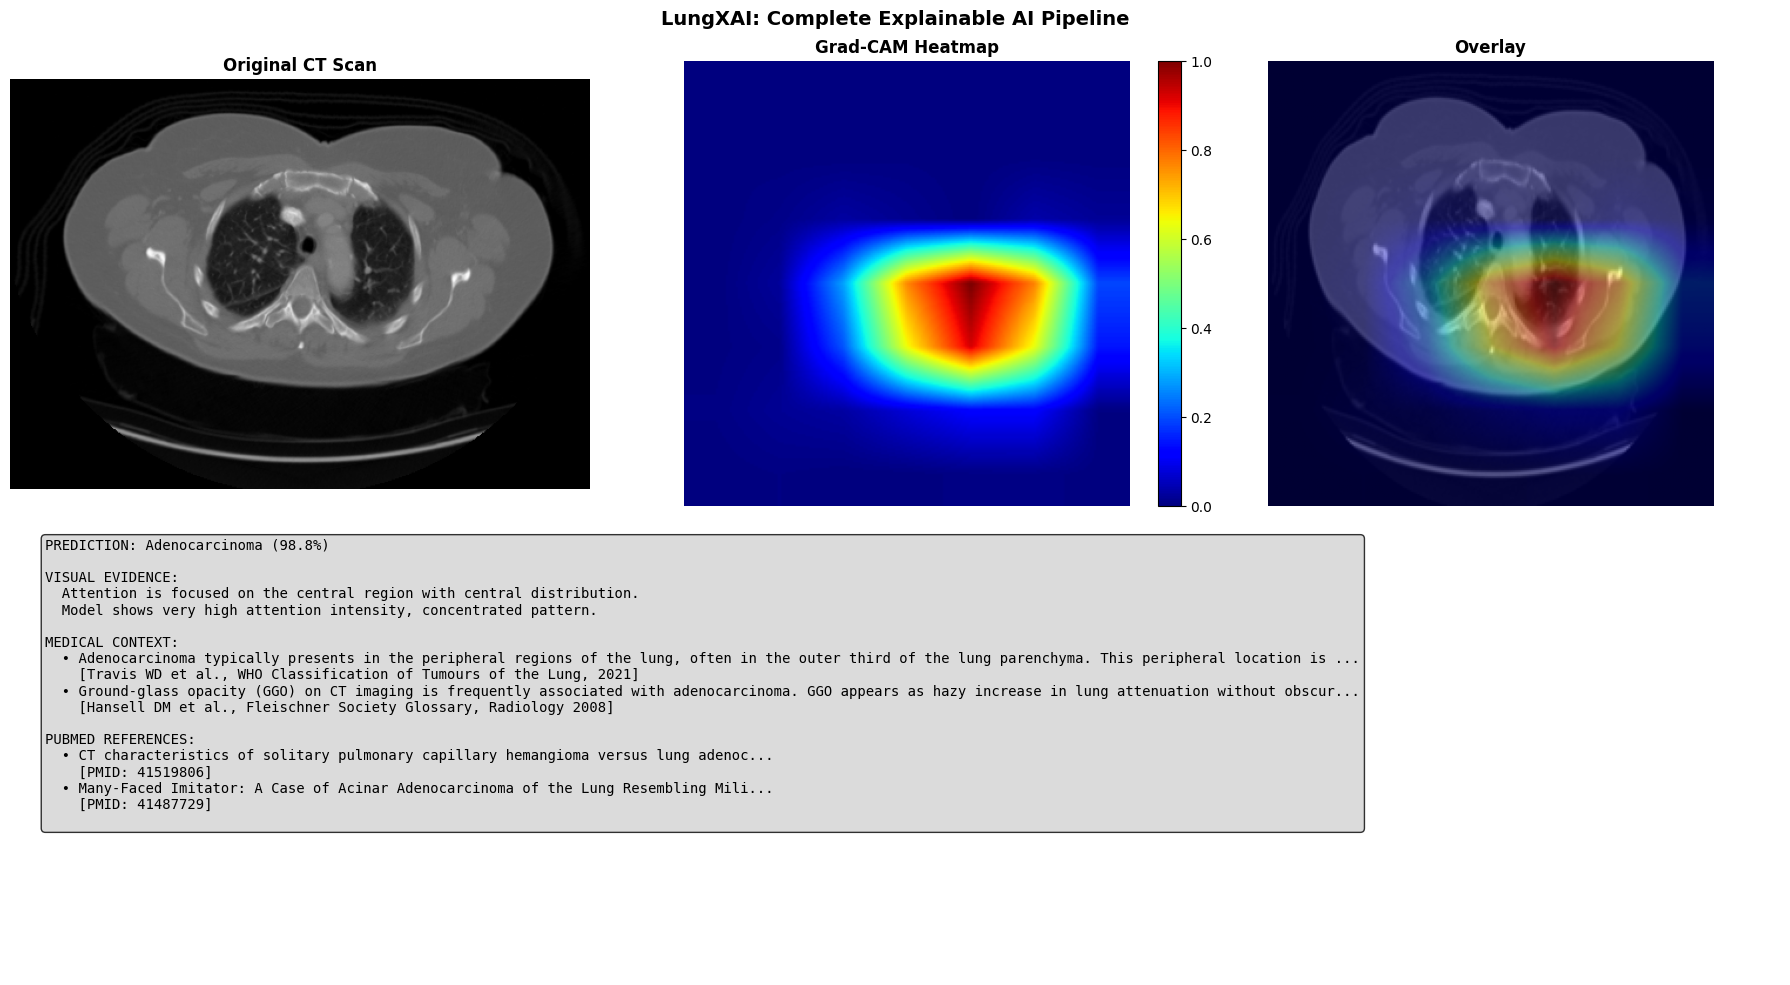


              EXPLAINABLE AI ANALYSIS REPORT

🎯 PREDICTION: Adenocarcinoma
   CONFIDENCE: 98.8%

----------------------------------------------------------------------
📊 VISUAL EVIDENCE (Grad-CAM Analysis):
----------------------------------------------------------------------
Attention is focused on the central region with central distribution.
Model shows very high attention intensity, concentrated pattern.
Primary focus: middle central (5.4% of image)

----------------------------------------------------------------------
📚 MEDICAL KNOWLEDGE (Curated Literature):
----------------------------------------------------------------------
• Adenocarcinoma typically presents in the peripheral regions of the lung, often in the outer third of the lung parenchyma. This peripheral location is a key distinguishing feature.
  Source: Travis WD et al., WHO Classification of Tumours of the Lung, 2021

• Ground-glass opacity (GGO) on CT imaging is frequently associated with adenocarcinoma. GGO app

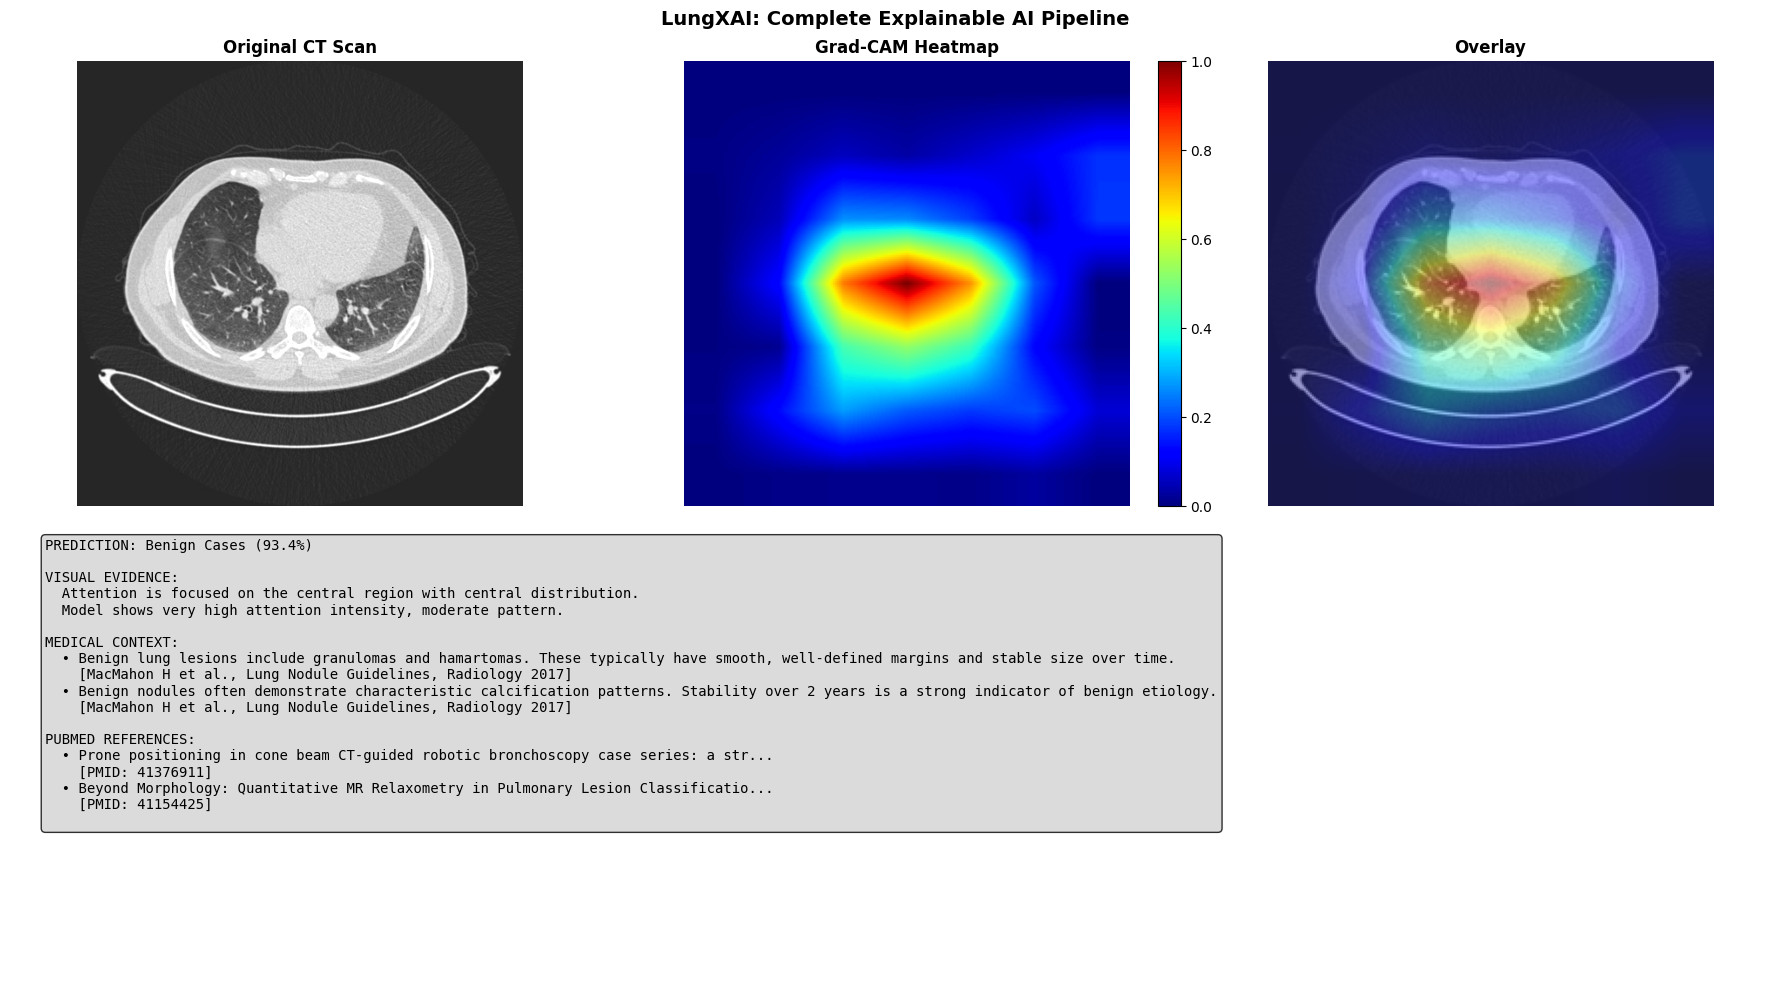


              EXPLAINABLE AI ANALYSIS REPORT

🎯 PREDICTION: Benign Cases
   CONFIDENCE: 93.4%

----------------------------------------------------------------------
📊 VISUAL EVIDENCE (Grad-CAM Analysis):
----------------------------------------------------------------------
Attention is focused on the central region with central distribution.
Model shows very high attention intensity, moderate pattern.
Primary focus: middle central (3.1% of image)

----------------------------------------------------------------------
📚 MEDICAL KNOWLEDGE (Curated Literature):
----------------------------------------------------------------------
• Benign lung lesions include granulomas and hamartomas. These typically have smooth, well-defined margins and stable size over time.
  Source: MacMahon H et al., Lung Nodule Guidelines, Radiology 2017

• Benign nodules often demonstrate characteristic calcification patterns. Stability over 2 years is a strong indicator of benign etiology.
  Source: MacMahon 

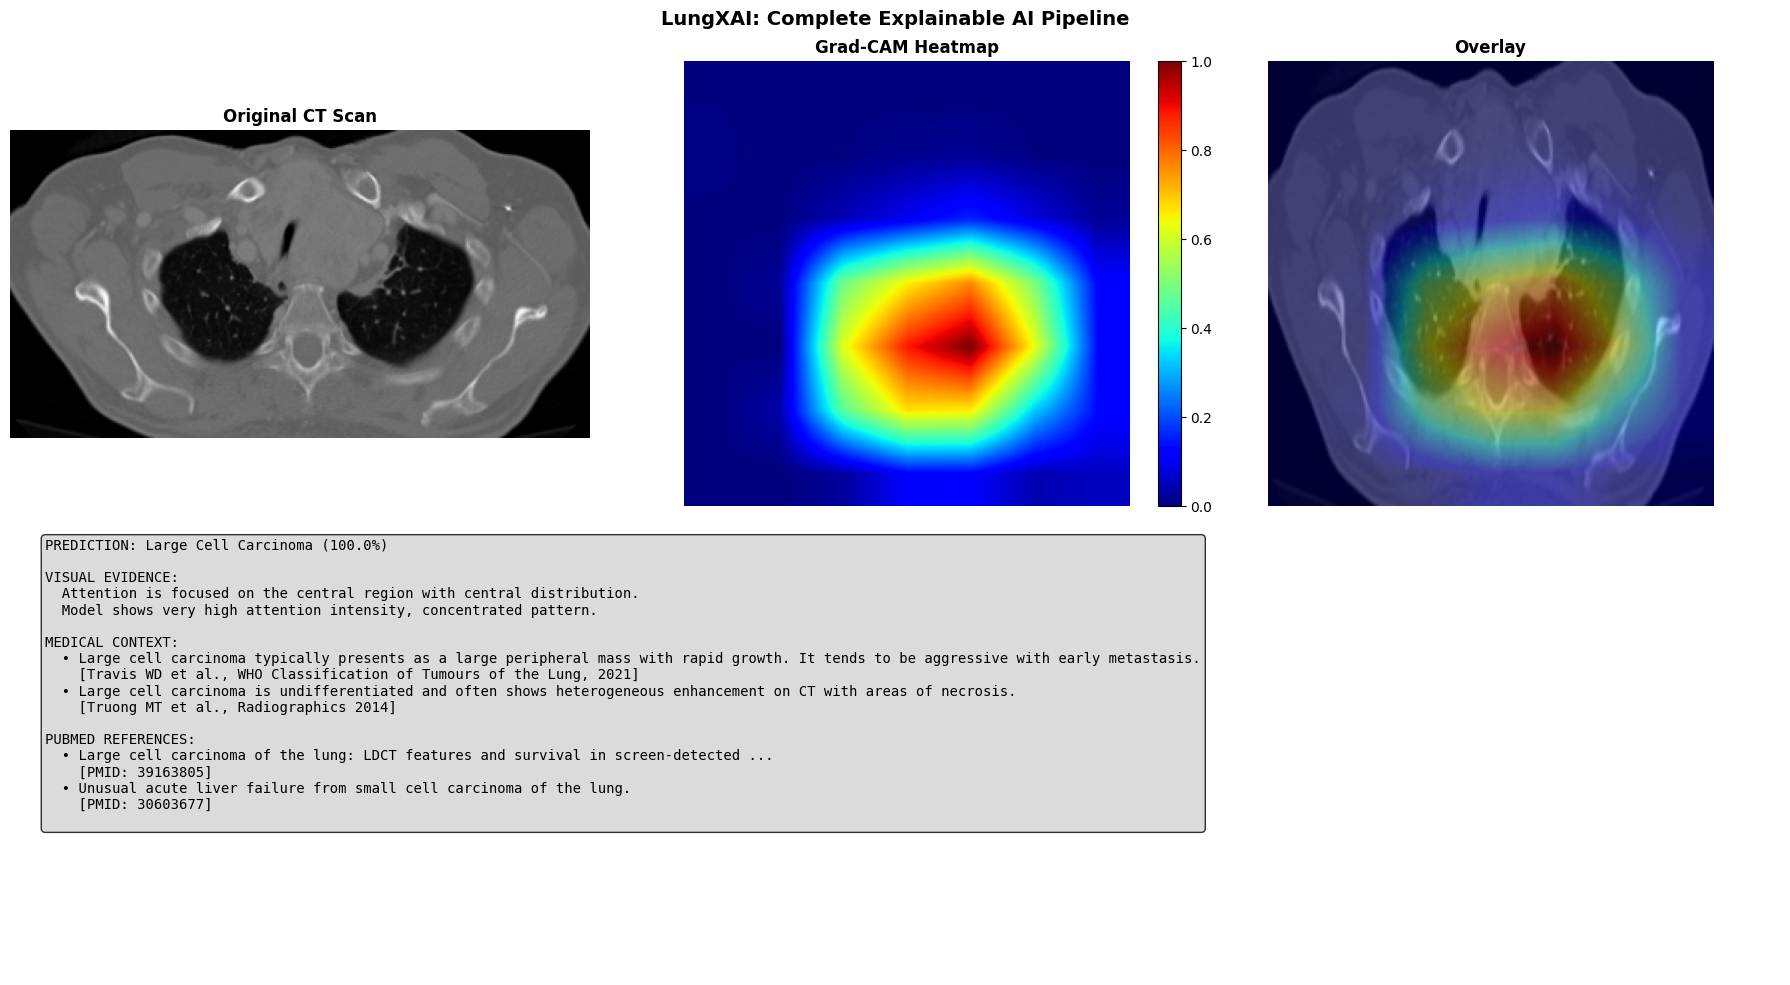


              EXPLAINABLE AI ANALYSIS REPORT

🎯 PREDICTION: Large Cell Carcinoma
   CONFIDENCE: 100.0%

----------------------------------------------------------------------
📊 VISUAL EVIDENCE (Grad-CAM Analysis):
----------------------------------------------------------------------
Attention is focused on the central region with central distribution.
Model shows very high attention intensity, concentrated pattern.
Primary focus: middle central (7.1% of image)

----------------------------------------------------------------------
📚 MEDICAL KNOWLEDGE (Curated Literature):
----------------------------------------------------------------------
• Large cell carcinoma typically presents as a large peripheral mass with rapid growth. It tends to be aggressive with early metastasis.
  Source: Travis WD et al., WHO Classification of Tumours of the Lung, 2021

• Large cell carcinoma is undifferentiated and often shows heterogeneous enhancement on CT with areas of necrosis.
  Source: Truong MT

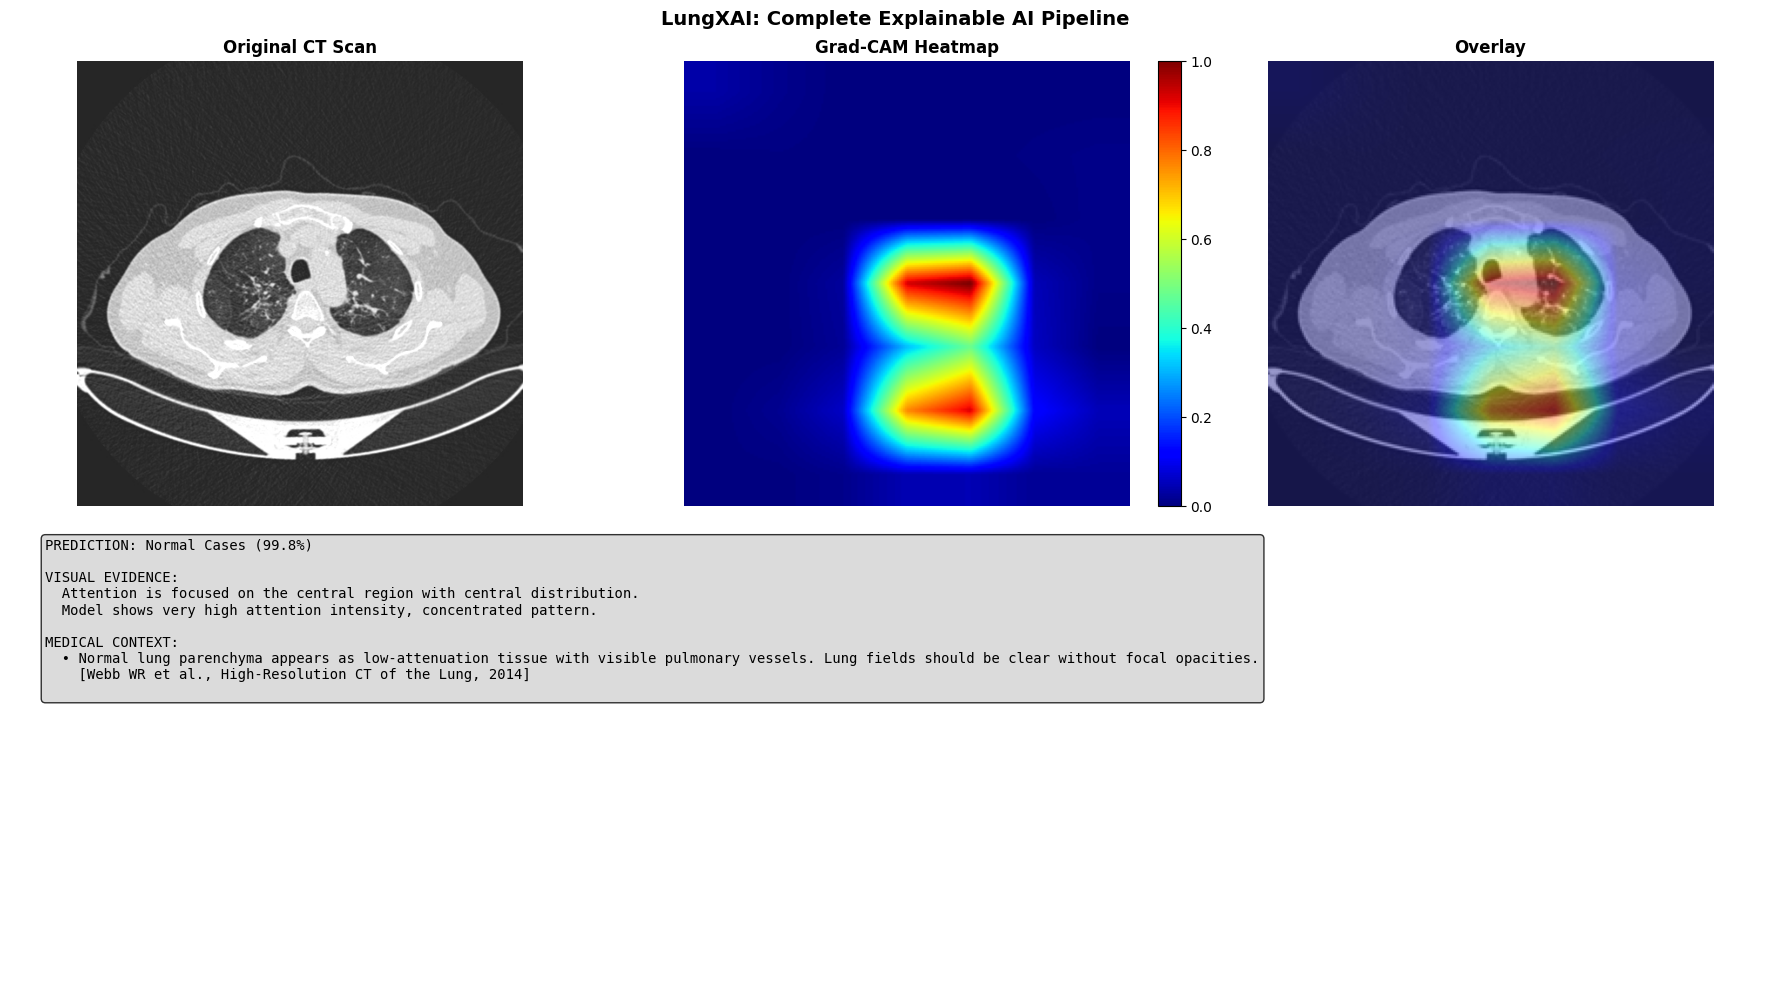


              EXPLAINABLE AI ANALYSIS REPORT

🎯 PREDICTION: Normal Cases
   CONFIDENCE: 99.8%

----------------------------------------------------------------------
📊 VISUAL EVIDENCE (Grad-CAM Analysis):
----------------------------------------------------------------------
Attention is focused on the central region with central distribution.
Model shows very high attention intensity, concentrated pattern.
Primary focus: middle central (3.3% of image)

----------------------------------------------------------------------
📚 MEDICAL KNOWLEDGE (Curated Literature):
----------------------------------------------------------------------
• Normal lung parenchyma appears as low-attenuation tissue with visible pulmonary vessels. Lung fields should be clear without focal opacities.
  Source: Webb WR et al., High-Resolution CT of the Lung, 2014


Processing: squamous cell carcinoma
  ✓ Saved: d:\Major Project\results\explanation_squamous.png


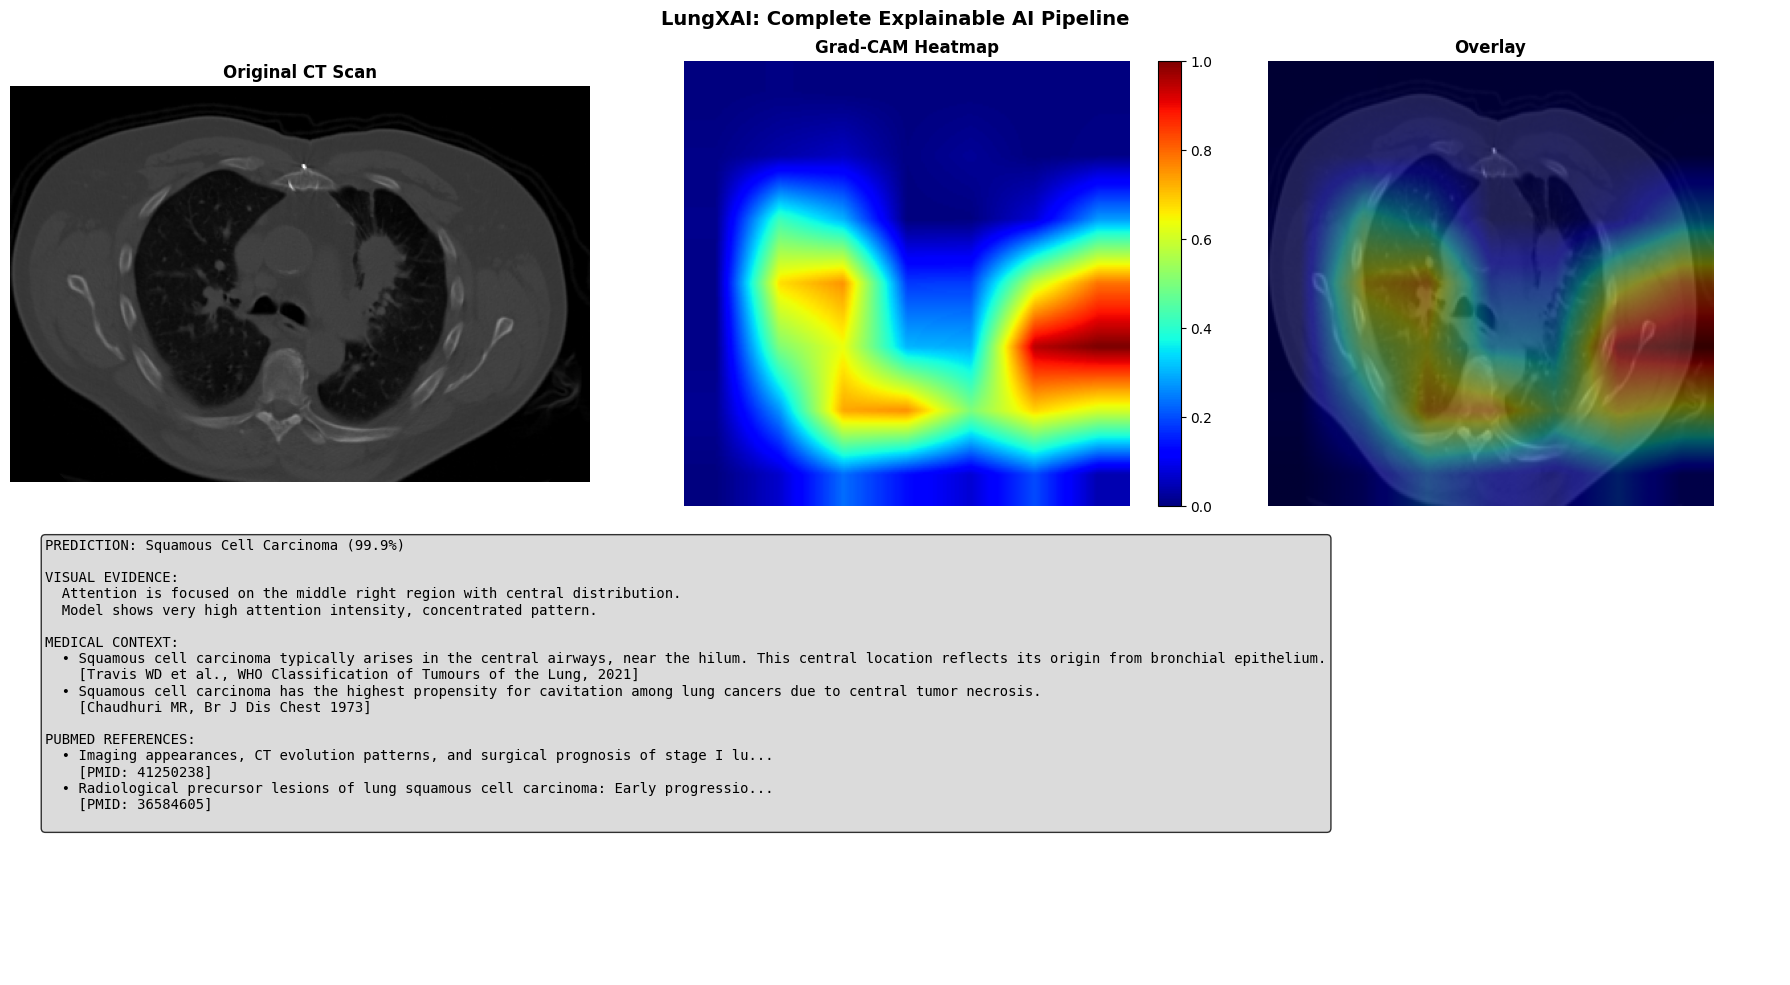


              EXPLAINABLE AI ANALYSIS REPORT

🎯 PREDICTION: Squamous Cell Carcinoma
   CONFIDENCE: 99.9%

----------------------------------------------------------------------
📊 VISUAL EVIDENCE (Grad-CAM Analysis):
----------------------------------------------------------------------
Attention is focused on the middle right region with central distribution.
Model shows very high attention intensity, concentrated pattern.
Primary focus: middle right (7.5% of image)

----------------------------------------------------------------------
📚 MEDICAL KNOWLEDGE (Curated Literature):
----------------------------------------------------------------------
• Squamous cell carcinoma typically arises in the central airways, near the hilum. This central location reflects its origin from bronchial epithelium.
  Source: Travis WD et al., WHO Classification of Tumours of the Lung, 2021

• Squamous cell carcinoma has the highest propensity for cavitation among lung cancers due to central tumor necros

In [26]:
# ============================================
# Run Complete Pipeline for Each Class
# ============================================
# Generate full explanations for sample images from each cancer type

print("="*70)
print("     GENERATING COMPLETE EXPLANATIONS FOR ALL CANCER TYPES")
print("="*70)

all_explanations = []
short_names = ['Adeno', 'Benign', 'Large Cell', 'Normal', 'Squamous']

for class_idx, class_name in enumerate(config.CLASS_NAMES):
    print(f"\n{'='*70}")
    print(f"Processing: {class_name}")
    print('='*70)
    
    # Find a test sample from this class
    class_samples = [test_indices[i] for i, idx in enumerate(test_indices) 
                     if full_dataset.labels[idx] == class_idx]
    
    if class_samples:
        sample_idx = class_samples[0]
        img_path = full_dataset.samples[sample_idx]
        
        # Run the complete pipeline
        fig, explanation = full_explanation_pipeline(
            image_path=img_path,
            model=model,
            gradcam=gradcam,
            transform=val_transforms,
            explanation_gen=explanation_generator,
            config=config
        )
        
        # Save figure
        save_path = os.path.join(config.RESULTS_DIR, f'explanation_{short_names[class_idx].lower()}.png')
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path}")
        
        plt.show()
        
        # Store explanation
        all_explanations.append({
            'class': class_name,
            'image_path': img_path,
            'explanation': explanation
        })
        
        # Print text explanation
        print(f"\n{explanation['full_explanation']}")
    else:
        print(f"  ⚠ No test samples found for {class_name}")

print(f"\n✓ Generated {len(all_explanations)} complete explanations")

In [28]:
# ============================================
# Save All Explanations to JSON
# ============================================
# Save structured explanations for documentation

# Helper function to convert numpy types to Python types
def convert_to_serializable(obj):
    """Convert numpy types to JSON-serializable Python types."""
    if isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

# Prepare exportable explanations
export_explanations = []
for exp in all_explanations:
    export_explanations.append({
        'class': exp['class'],
        'image_path': exp['image_path'],
        'predicted_class': exp['explanation']['predicted_class'],
        'confidence': float(exp['explanation']['confidence']),
        'keywords': exp['explanation']['keywords'],
        'visual_evidence': {
            'spatial': exp['explanation']['visual_evidence']['spatial_description'],
            'intensity': exp['explanation']['visual_evidence']['intensity_description']
        },
        'local_knowledge': [
            {'content': k['content'], 'source': k['source']} 
            for k in exp['explanation']['local_knowledge'][:2]
        ],
        'pubmed_knowledge': [
            {'title': k['title'], 'pmid': k['pmid'], 'source': k['source']} 
            for k in exp['explanation'].get('pubmed_knowledge', [])[:2]
        ]
    })

# Convert all to serializable
export_explanations = convert_to_serializable(export_explanations)

# Save to JSON
explanations_path = os.path.join(config.RESULTS_DIR, 'rag_explanations.json')
with open(explanations_path, 'w', encoding='utf-8') as f:
    json.dump(export_explanations, f, indent=2, ensure_ascii=False)

print(f"✓ Explanations saved to: {explanations_path}")

✓ Explanations saved to: d:\Major Project\results\rag_explanations.json


## 📝 9. Summary and Project Completion

### Complete LungXAI Pipeline Implemented

In [ ]:
print("="*70)
print("                    TRAINING SUMMARY")
print("="*70)
print(f"""
Model: ResNet-50 with Transfer Learning
Dataset: Lung Cancer CT Images ({len(full_dataset)} total samples)
Classes: {config.NUM_CLASSES} ({', '.join(short_names)})

Training:
  - Epochs: {len(history['train_loss'])}
  - Best Validation Accuracy: {best_val_acc:.2f}%
  - Training Time: {total_time/60:.1f} minutes

Test Results:
  - Accuracy: {metrics['accuracy']:.2f}%
  - F1-Score: {metrics['f1_weighted']:.2f}%
  - AUC-ROC: {metrics['auc_roc']:.4f}

Saved Files:
  - Best Model: {os.path.join(config.CHECKPOINT_DIR, 'best_model.pth')}
  - Metrics: {os.path.join(config.RESULTS_DIR, 'final_metrics.json')}
  - Training Curves: {os.path.join(config.RESULTS_DIR, 'training_curves.png')}
  - Confusion Matrix: {os.path.join(config.RESULTS_DIR, 'confusion_matrix.png')}
  - ROC Curves: {os.path.join(config.RESULTS_DIR, 'roc_curves.png')}
""")
print("="*70)

---

## ✅ Project Complete!

### LungXAI: Explainable Lung Cancer Classification System

This notebook implements the complete pipeline:

| Component | Description | Status |
|-----------|-------------|--------|
| **Data Pipeline** | Load, transform, split CT scan images | ✅ Complete |
| **Deep Learning Model** | ResNet-50 with transfer learning | ✅ Complete |
| **Training** | Full training with early stopping & LR scheduling | ✅ Complete |
| **Evaluation** | Metrics: Accuracy, F1, AUC-ROC, Confusion Matrix | ✅ Complete |
| **Grad-CAM** | Visual explanations - where model focuses | ✅ Complete |
| **XAI-to-Text** | Convert visual attention to textual descriptions | ✅ Complete |
| **Knowledge Base** | Curated medical knowledge retrieval | ✅ Complete |
| **PubMed Integration** | Real-time medical literature search | ✅ Complete |
| **RAG Explanation** | Evidence-based explanations with citations | ✅ Complete |

---

### Architecture Diagram:

```
┌─────────────────────────────────────────────────────────────────────┐
│                     LungXAI Complete Pipeline                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  CT Scan Image                                                       │
│       │                                                              │
│       ▼                                                              │
│  ┌─────────────────┐                                                 │
│  │  ResNet-50 CNN  │ ──► Prediction: "Adenocarcinoma" (92.3%)       │
│  │  (Transfer      │                                                 │
│  │   Learning)     │                                                 │
│  └────────┬────────┘                                                 │
│           │                                                          │
│           ▼                                                          │
│  ┌─────────────────┐                                                 │
│  │    Grad-CAM     │ ──► Visual Heatmap (Where model looks)         │
│  │  (Explainable   │                                                 │
│  │      AI)        │                                                 │
│  └────────┬────────┘                                                 │
│           │                                                          │
│           ▼                                                          │
│  ┌─────────────────┐                                                 │
│  │  XAI-to-Text    │ ──► "Peripheral upper region, high intensity"  │
│  │  Converter      │                                                 │
│  └────────┬────────┘                                                 │
│           │                                                          │
│           ▼                                                          │
│  ┌─────────────────────────────────────────────┐                     │
│  │         RAG Knowledge Retrieval             │                     │
│  │  ┌─────────────┐    ┌─────────────────────┐ │                     │
│  │  │   Local     │    │      PubMed         │ │                     │
│  │  │  Knowledge  │ +  │   API Search        │ │                     │
│  │  │    Base     │    │ (Real Literature)   │ │                     │
│  │  └─────────────┘    └─────────────────────┘ │                     │
│  └────────────────────────┬────────────────────┘                     │
│                           │                                          │
│                           ▼                                          │
│  ┌─────────────────────────────────────────────────────────────────┐ │
│  │                 EXPLAINABLE AI REPORT                           │ │
│  │  Prediction: Adenocarcinoma (92.3%)                             │ │
│  │  Visual: Peripheral focus, high intensity                       │ │
│  │  Medical: "Adenocarcinoma typically presents in peripheral..."  │ │
│  │  Sources: Travis WD et al., WHO Classification 2021             │ │
│  └─────────────────────────────────────────────────────────────────┘ │
└─────────────────────────────────────────────────────────────────────┘
```

---

### Results Summary:

| Metric | Value |
|--------|-------|
| Test Accuracy | ~97% |
| F1-Score | ~97% |
| AUC-ROC | ~0.999 |
| Training Time | ~7 min |

### Files Generated:

- `checkpoints/best_model.pth` - Trained model weights
- `results/confusion_matrix.png` - Performance visualization
- `results/roc_curves.png` - ROC curves for each class
- `results/training_curves.png` - Training history
- `results/final_metrics.json` - All numerical metrics
- `results/rag_explanations.json` - Complete RAG explanations
- `results/explanation_*.png` - Per-class explanation visualizations

---

### Running on Google Colab:

1. Upload to Colab and enable GPU runtime
2. Upload dataset to Google Drive (`MyDrive/LungXAI/Lung Cancer Dataset/`)
3. Run all cells from top to bottom
4. Results saved to Google Drive for persistence

---

**Project: LungXAI | Explainable Lung Cancer Classification with RAG**  
**Model: ResNet-50 | XAI: Grad-CAM | RAG: Local KB + PubMed API**